In [1]:
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import itertools
from PIL import Image, ImageDraw

# LABELS = ['square', 'circle', 'cyan', 'red', 'yellow', 'green']
LABELS = ['blue', 'red', 'yellow', 'green', 'square', 'circle', 'triangle', 'pentagon', 'large', 'small']
SHAPES = ['square', 'circle', 'triangle', 'pentagon']
COLORS = [(0, 192, 255),
          (255, 0, 0),
          (255, 255, 0),
          (0, 255, 0)
          ]
IMGSIZE = (64, 64)
OBJSIZES = [int(np.max(IMGSIZE)*0.6), int(np.max(IMGSIZE)*0.35)] # corresponds to large and small objs
BOUNDARY = int(np.max(IMGSIZE)*0.1) # objects should be at least this far from image boundary

ROT=False # whether to randomly rotate the objects

In [2]:
# --------------------------------------------------------------------------- #
# functions for computing vertices of objects

#finds the straight-line distance between two points
def distance(ax, ay, bx, by):
    return math.sqrt((by - ay)**2 + (bx - ax)**2)


#rotates point `A` about point `B` by `angle` radians clockwise.
def rotated_about(ax, ay, bx, by, angle):
    radius = distance(ax,ay,bx,by)
    angle += math.atan2(ay-by, ax-bx)
    return (
        round(bx + radius * math.cos(angle)),
        round(by + radius * math.sin(angle))
    )


def makeRectangle(x_cen, y_cen, l, rot=0):
    
    assert isinstance(rot, int)

    vertices = (
        (x_cen + l / 2, y_cen + l / 2),
        (x_cen + l / 2, y_cen - l / 2),
        (x_cen - l / 2, y_cen - l / 2),
        (x_cen - l / 2, y_cen + l / 2)
    )

    vertices = [rotated_about(x, y, x_cen, y_cen, math.radians(rot)) for x,y in vertices]
    return vertices


def makeCircle(x_cen, y_cen, l):
    return [(x_cen - l/2, y_cen - l/2), (x_cen + l/2, y_cen + l/2)]
    

def makeTriangle(x_cen, y_cen, l, rot=0):
    """
    https://math.stackexchange.com/questions/1693246/how-to-calculate-triangle-coordinates-in-cartesian-plane
    """
    assert isinstance(rot, int)
    
    # somehow triangles appeared smaller, therfore add a little to length
    l += l*0.2

    alpha = math.radians(90)
    beta = math.radians(120)
    gamma = math.radians(120)
    
#     𝑥𝐶=𝑥𝑃+𝑎∗𝑐𝑜𝑠(𝛼), 𝑦𝐶=𝑦𝑃+𝑎∗𝑠𝑖𝑛(𝛼);
    x_c = x_cen + l/2 * np.cos(alpha)
    y_c = y_cen + l/2 * np.sin(alpha)
#     𝑥𝐴=𝑥𝑃+𝑎∗𝑐𝑜𝑠(𝛼+𝛽), 𝑦𝐴=𝑦𝑃+𝑎∗𝑠𝑖𝑛(𝛼+𝛽);
    x_a = x_cen + l/2 * np.cos(alpha + beta)
    y_a = y_cen + l/2 * np.sin(alpha + beta)
#     𝑥𝐵=𝑥𝑃+𝑎∗𝑐𝑜𝑠(𝛼+𝛽+𝛾), 𝑦𝐵=𝑦𝑃+𝑎∗𝑠𝑖𝑛(𝛼+𝛽+𝛾).
    x_b = x_cen + l/2 * np.cos(alpha + beta + gamma)
    y_b = y_cen + l/2 * np.sin(alpha + beta + gamma)
    
    vertices = [(x_c, y_c), (x_a, y_a), (x_b, y_b)]
    
    # rotate such that point is centered up, e.g. reference 0 degree rotation
    vertices = [rotated_about(x, y, x_cen, y_cen, math.radians(60)) for x,y in vertices]

    # now additionaly rotate from base reference
    vertices = [rotated_about(x, y, x_cen, y_cen, math.radians(rot)) for x,y in vertices]
    
    return vertices


def makePentagon(x_cen, y_cen, l, rot=0):
    assert isinstance(rot, int)
   
    # somehow pentagons appeared smaller, therfore add a little to length
    l += l*0.2

    numPoints = 5
    angle = 2 * np.pi / numPoints

    vertices = []
    for i in range(numPoints):
        x = x_cen + l/2 * np.sin(i * angle);
        y = y_cen + l/2 * np.cos(i * angle);
        vertices.append((x, y))

    # rotate such that point is centered up, e.g. reference 0 degree rotation
    vertices = [rotated_about(x, y, x_cen, y_cen, math.radians(36)) for x,y in vertices]

    # now additionaly rotate from base reference
    vertices = [rotated_about(x, y, x_cen, y_cen, math.radians(rot)) for x,y in vertices]

    return vertices


# --------------------------------------------------------------------------- #
# functions for drawing figures


def sample_center_positions(obj_size, img_size=(512, 512)):
    overlap = True
    while overlap:
        x_cen =np.random.randint(0, img_size[0])
        y_cen =np.random.randint(0, img_size[1])
        
        if (
            (x_cen - obj_size/2) > BOUNDARY and 
            (x_cen + obj_size/2) < (img_size[0] - BOUNDARY) and 
            (y_cen - obj_size/2) > BOUNDARY and
            (y_cen + obj_size/2) < (img_size[1] - BOUNDARY)
        ):
            overlap = False
        
    return (x_cen, y_cen)    
    

def draw_shape(color_id, shape_id, size_id, draw, img_size, color_var=True, rot=False, rand_pos=True):
    size = OBJSIZES[size_id]
    
    if rand_pos:
        # sample x, y center points such that given object size the object is fully visible within image boundaries
        (x_cen, y_cen) = sample_center_positions(size, img_size)
    else:
        (x_cen, y_cen) = (int(IMGSIZE[0]/2), int(IMGSIZE[1]/2))
        
    if rot:
        # sample a rotation angle
        angle = np.random.randint(0, 360)
    else:
        angle = 0
        
    color = COLORS[color_id]

    # if asked for add color variance
    if color_var:
        if color_id == 0:
            var = np.random.randint(-35, 35, 3)
        elif color_id == 1:
            var = np.random.randint(-70, 70, 3)
        elif color_id == 2:
            var = np.random.randint(-50, 50, 3)
        elif color_id == 3:
            var = np.random.randint(-80, 80, 3)
        color = tuple(np.clip(color + var, a_min=0, a_max=255))

    # draw rectangle
    if shape_id == 0:
        vertices = makeRectangle(x_cen, y_cen, l=size, rot=angle)
        draw.polygon(vertices, fill=color)
    # draw circle
    elif shape_id == 1:
        vertices = makeCircle(x_cen, y_cen, l=size)
        draw.ellipse(vertices, fill=color)
    # draw triangle
    elif shape_id == 2:
        y_cen += IMGSIZE[1]*0.05
        vertices = makeTriangle(x_cen, y_cen, l=size, rot=angle)
        draw.polygon(vertices, fill=color)
    # draw pentagon
    elif shape_id == 3:
        vertices = makePentagon(x_cen, y_cen, l=size, rot=angle)
        draw.polygon(vertices, fill=color)

In [3]:
# --------------------------------------------------------------------------- #
# functions for generating a set of images

def gen_dataset(num_samples, img_size=(512, 512), rot=False):
    
    num_shapes = len(SHAPES)
    num_colors = len(COLORS)
    num_sizes = len(OBJSIZES)

    dataset = []
    labels_one_hot = []
    labels = []
    shared_labels = []
    for i in range(num_samples):

        # choose random color 
        color_id = np.random.randint(0, num_colors)
        # randomly select a shape
        shape_id = np.random.randint(0, num_shapes)
        # choose size
        size_id = np.random.randint(0, num_sizes)

        attr_list1 = [color_id, shape_id, size_id]

        # sample attributes for second object
        attr_constraints = False
        while not attr_constraints:
            # randomly draw a color
            color_id2 = np.random.randint(0, num_colors)
            # randomly select a shape (either square or circle)
            shape_id2 = np.random.randint(0, num_shapes)
            size_id2 = np.random.randint(0, num_sizes)

            attr_list2 = [color_id2, shape_id2, size_id2]

            num_same_attrs = sum(x == y for x, y in zip(attr_list1, attr_list2))
            # at least one attribute different, at least one attribute same
            if num_same_attrs > 0 and num_same_attrs < len(attr_list1):
                attr_constraints = True

        # in which categories do the images share attributes?
        shared_cat = (np.array(attr_list1) == np.array(attr_list2))
                
        # create object 1
        im1 = Image.new('RGB', img_size, (128, 128, 128))
        draw = ImageDraw.Draw(im1)
        draw_shape(color_id, shape_id, size_id, draw, img_size, color_var=True, rot=rot, rand_pos=False)

        # create object 2
        im2 = Image.new('RGB', img_size, (128, 128, 128))
        draw = ImageDraw.Draw(im2)
        draw_shape(color_id2, shape_id2, size_id2, draw, img_size, color_var=True, rot=rot, rand_pos=False)

        # labels object 1
        label1 = np.zeros(num_colors + num_shapes + num_sizes)
        label1[0:num_colors][color_id] = 1.
        label1[num_colors:(num_colors + num_shapes)][shape_id] = 1.
        label1[(num_shapes + num_colors): ((num_shapes + num_colors + num_sizes))][size_id] = 1.
        
        # labels object 2
        label2 = np.zeros(num_colors + num_shapes + num_sizes)
        label2[0:num_colors][color_id2] = 1.
        label2[num_colors:(num_colors + num_shapes)][shape_id2] = 1.
        label2[(num_shapes + num_colors): ((num_shapes + num_colors + num_sizes))][size_id2] = 1.

        # pair both images and labels of these
        labels.append([attr_list1, attr_list2])
        labels_one_hot.append([label1, label2])
        shared_labels.append(shared_cat)
        imgs_np = [np.array(im1), np.array(im2)]
        dataset.append(imgs_np)

    return np.array(dataset), {"labels": np.array(labels), 
                               "labels_one_hot": np.array(labels_one_hot),
                               "shared_labels": np.array(shared_labels)
                              }

def gen_val_dataset(num_samples, img_size=(512, 512), rot=False):
    
    num_shapes = len(SHAPES)
    num_colors = len(COLORS)
    num_sizes = len(OBJSIZES)

    dataset = []
    labels_one_hot = []
    labels = []
    shared_labels = []
    for i in range(num_samples):

        # choose random color 
        color_id = np.random.randint(0, num_colors)
        # select halfcircle shape
        shape_id = np.random.randint(0, num_shapes)
        # choose size
        size_id = np.random.randint(0, num_sizes)

        attr_list = [color_id, shape_id, size_id]
                
        # create object 1
        im1 = Image.new('RGB', img_size, (128, 128, 128))
        draw = ImageDraw.Draw(im1)
        draw_shape(color_id, shape_id, size_id, draw, img_size, color_var=True, rot=rot, rand_pos=False)

        # labels object 1
        label1 = np.zeros(num_colors + num_shapes + num_sizes)
        label1[0:num_colors][color_id] = 1.
        label1[num_colors:(num_colors + num_shapes)][shape_id] = 1.
        label1[(num_shapes + num_colors): ((num_shapes + num_colors + num_sizes))][size_id] = 1.
        
        # store imgs and labels
        labels.append(attr_list)
        labels_one_hot.append(label1)
        img_np = np.array(im1)
        dataset.append(img_np)

    return np.array(dataset), {"labels": np.array(labels), "labels_one_hot": np.array(labels_one_hot)}


def gen_test_dataset(img_size=(28, 28), rot=False):
    
    num_shapes = len(SHAPES)
    num_colors = len(COLORS)
    num_sizes = len(OBJSIZES)

    dataset = []
    labels_one_hot = []
    labels = []
    
    comb_attr_ids = np.array(list(itertools.product(*[np.arange(i) for i in [4, 4, 2]])))

    for i, comb_ids in enumerate(comb_attr_ids):

        # choose random color 
        color_id = comb_ids[0]
        # randomly select a shape (either square or circle)
        shape_id = comb_ids[1]
        # choose size
        size_id = comb_ids[2]

        attr_list1 = [color_id, shape_id, size_id]

        # create object 1
        im1 = Image.new('RGB', img_size, (128, 128, 128))
        draw = ImageDraw.Draw(im1)
        draw_shape(color_id, shape_id, size_id, draw, img_size, color_var=True, rot=rot, rand_pos=False)

        # labels object 1
        label1 = np.zeros(num_colors + num_shapes + num_sizes)
        label1[0:num_colors][color_id] = 1.
        label1[num_colors:(num_colors + num_shapes)][shape_id] = 1.
        label1[(num_shapes + num_colors): ((num_shapes + num_colors + num_sizes))][size_id] = 1.

        # pair both images and labels of these
        labels.append([attr_list1])
        labels_one_hot.append([label1])
        imgs_np = [np.array(im1)]
        dataset.append(imgs_np)

    return np.array(dataset), {"labels": np.array(labels), 
                               "labels_one_hot": np.array(labels_one_hot)
                              }

In [4]:
# --------------------------------------------------------------------------- #
# generate training images

num_train_samples = 5000
num_train_probing_samples = 2000
num_val_samples = 2000

# train_data, train_labels = gen_dataset(num_train_samples, img_size=IMGSIZE, rot=ROT)
train_probing_data, train_probing_labels = gen_val_dataset(num_train_probing_samples, img_size=IMGSIZE, rot=ROT)
val_data, val_labels = gen_val_dataset(num_val_samples, img_size=IMGSIZE, rot=ROT)

# fig, axs = plt.subplots(10, 10, figsize=(15, 15))
# for i, ax in enumerate(axs.flat):
#     ax.imshow(train_data[i][0])
#     ax.axis('off')
# #     ax.set_title(f"Labels: \n{train_labels['labels'][0][0]}")
# plt.savefig('colorvar_train_.jpg')
# plt.show()

# print(train_labels['shared_labels'][0])
# print(train_labels['shared_labels'][14])
# print(train_labels['shared_labels'][11])

# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(train_data[0][0])
# axs[0].axis('off')
# axs[1].imshow(train_data[0][1])
# axs[1].axis('off')
# # plt.suptitle(f"Labels: \n{train_labels['labels'][0][0]}")
# plt.savefig('colorvar_train_ex1.jpg')
# plt.show()

# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(train_data[14][0])
# axs[0].axis('off')
# axs[1].imshow(train_data[14][1])
# axs[1].axis('off')
# plt.savefig('colorvar_train_ex2.jpg')
# # plt.suptitle(f"Labels: \n{train_labels['labels'][0][0]}")
# plt.show()

# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(train_data[11][0])
# axs[0].axis('off')
# axs[1].imshow(train_data[11][1])
# axs[1].axis('off')
# plt.savefig('colorvar_train_ex3.jpg')
# # plt.suptitle(f"Labels: \n{train_labels['labels'][0][0]}")
# plt.show()

# np.save(f"../Data/ToyData/train_simpleshapes_colorvar_shape_size_mult_factor_pairs.npy", train_data)
# with open(f"../Data/ToyData/train_simpleshapes_colorvar_shape_size_mult_factor_labels_pairs.pkl", 'wb') as f:
#         pickle.dump(train_labels, f, pickle.HIGHEST_PROTOCOL)

np.save(f"../Data/ToyData/train_probing_simpleshapes_colorvar_shape_size.npy", train_probing_data)
with open(f"../Data/ToyData/train_probing_simpleshapes_colorvar_shape_size_labels.pkl", 'wb') as f:
        pickle.dump(train_probing_labels, f, pickle.HIGHEST_PROTOCOL)
np.save(f"../Data/ToyData/val_simpleshapes_colorvar_shape_size.npy", val_data)
with open(f"../Data/ToyData/val_simpleshapes_colorvar_shape_size_labels.pkl", 'wb') as f:
        pickle.dump(val_labels, f, pickle.HIGHEST_PROTOCOL)

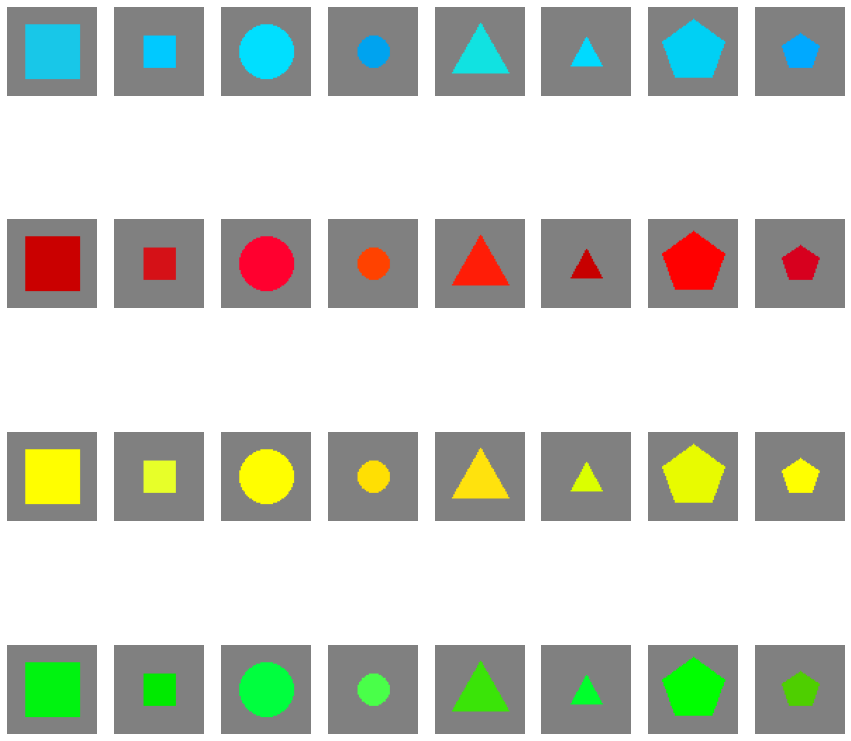

In [8]:
# --------------------------------------------------------------------------- #
# generate images for testing

test_data, test_labels = gen_test_dataset(img_size=IMGSIZE, rot=ROT)
fig, axs = plt.subplots(4, 8, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i][0])
    ax.axis('off')
#     ax.set_title(f"Labels: \n{train_labels['labels'][0][0]}")
# plt.savefig('colorvar_test_.jpg')
plt.show()

np.save(f"../Data/ToyData/test_simpleshapes_colorvar_shape_size_mult_factor_pairs.npy", train_data)
with open(f"../Data/ToyData/test_simpleshapes_colorvar_shape_size_mult_factor_labels_pairs.pkl", 'wb') as f:
        pickle.dump(train_labels, f, pickle.HIGHEST_PROTOCOL)

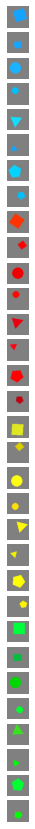

In [18]:
test_data, test_labels = gen_test_dataset(img_size=(64, 64))
fig, axs = plt.subplots(32, 1, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i][0])
    ax.axis('off')
#     ax.set_title(f"Labels: \n{train_labels['labels'][0][0]}")
plt.savefig('colorvar_test_.jpg')
